### Student Name: Roshnaey Khattak

In [1]:
#TODO: import the modules
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
import sklearn.feature_selection
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
import datetime
import numpy as np
import datetime
from datetime import date
from datetime import time
from datetime import datetime
import matplotlib.pyplot as plt

### Step 1 - Load the data

<AxesSubplot:>

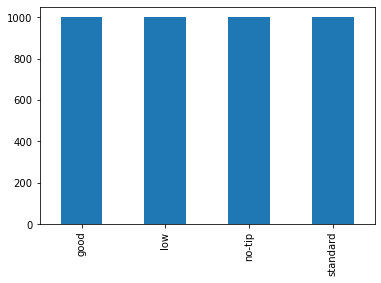

In [2]:
sample_size = 1000
file_path   = '/Users/roshnaey/Desktop/trip_data.csv' #TODO: provide the file path or URL to the dataset `trip_data.csv`

df = pd.read_csv(file_path, parse_dates = True)
df = df.groupby('tip').apply(lambda x: x.sample(sample_size))
df = df.sample(frac=1) #shuffle the dataframe rows

#visualize the sample data, which contain 1000 observations from each class
df.tip.value_counts().sort_index().plot.bar()

In [3]:
print (df.tip)

tip             
standard  85747     standard
          121026    standard
good      65516         good
low       34715          low
good      48851         good
                      ...   
standard  6442      standard
no-tip    130754      no-tip
good      25792         good
standard  32123     standard
          11923     standard
Name: tip, Length: 4000, dtype: object


### Step 2: Create a new feature called `trip_duration`

In [4]:
#Create a new feature called trip_duration and add it to the dataframe

df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

In [5]:
pickup = pd.to_datetime(df['lpep_pickup_datetime'])
dropoff = pd.to_datetime(df['lpep_dropoff_datetime'])
elapsed_time = dropoff - pickup

In [6]:
trip_duration = pd.to_numeric(elapsed_time.dt.seconds, downcast = 'integer')

In [7]:
#TODO: Calculate the difference between `lpep_pickup_datetime` and `lpep_dropoff_datetime` in seconds (this should be a positive number).

df['trip_duration'] = trip_duration #TODO: store the elapsed time (from above) into the dataframe.
print(df.trip_duration)

tip             
standard  85747      801
          121026    1528
good      65516      206
low       34715      500
good      48851      352
                    ... 
standard  6442       252
no-tip    130754     424
good      25792      601
standard  32123      450
          11923     1536
Name: trip_duration, Length: 4000, dtype: int32


In [8]:
#Remove the `lpep_pickup_datetime` and `lpep_dropoff_datetime` from the dataframe.
del df['lpep_dropoff_datetime']
del df['lpep_pickup_datetime']

### Step 3: Encode the labels in the `tip` field.
Use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) in scikit learn.

In [9]:
#Encode the class labels

#TODO: Initialize the `LabelEncoder`
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [10]:
df['tip'].value_counts()

low         1000
standard    1000
no-tip      1000
good        1000
Name: tip, dtype: int64

In [11]:
#TODO: Fit the `LabelEncoder` to the class labels in the 'tip' field
le.fit(df.tip)
#le.fit(["no-tip", "low", "standard", "good"])

LabelEncoder()

In [12]:
#TODO: Use the `LabelEncoder` to encode class labels in the 'tip' field.
le.classes_
list(le.classes_)
le.transform(df.tip)

array([3, 3, 0, ..., 0, 3, 3])

In [13]:
#TODO: Display the encoded labels
list(le.inverse_transform([2, 1, 3, 0]))

['no-tip', 'low', 'standard', 'good']

In [14]:
df['tip_labeled'] = le.transform(df.tip)

In [15]:
del df['tip']

df.head()

VendorID  RatecodeID  PULocationID  DOLocationID  \
tip                                                                 
standard 85747        2.0         1.0           166           236   
         121026       2.0         1.0             7           161   
good     65516        2.0         1.0           260            83   
low      34715        2.0         1.0            33            33   
good     48851        1.0         1.0           244           244   

                 passenger_count  trip_distance  fare_amount  extra  mta_tax  \
tip                                                                            
standard 85747               1.0           2.43         11.0    0.5      0.5   
         121026              1.0           4.10         18.0    0.0      0.5   
good     65516               1.0           0.53          4.5    0.5      0.5   
low      34715               2.0           1.25          7.0    1.0      0.5   
good     48851               1.0           0.80          6.0    0.0      0.5   

                 tolls_amount  improvement_surcharge  total_amount  trip_type  \
tip                                                                             
standard 85747            0.0                    0.3         18.81        1.0   
         121026           0.0                    0.3         25.86        1.0   
good     65516            0.0                    0.3          6.96        1.0   
low      34715            0.0                    0.3         10.56        1.0   
good     48851            0.0                    0.3          9.80        1.0   

                 congestion_surcharge  trip_duration  tip_labeled  
tip                                                                
standard 85747                   2.75            801            3  
         121026                  2.75           1528            3  
good     65516                   0.00            206            0  
low      34715                   0.00            500            1  
good     48851                   0.00            352            0

In [16]:
#assign the input features and the class labels to variables 'X' and 'y' respectively.

#features_columns = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'trip_type', 'congestion_surcharge', 'trip_duration']

X = df.iloc[:,0:15] #input features

y = df.iloc[:,15] #TODO: assign the encoded labels to a variale 'y'.

In [17]:
print(y)

tip             
standard  85747     3
          121026    3
good      65516     0
low       34715     1
good      48851     0
                   ..
standard  6442      3
no-tip    130754    2
good      25792     0
standard  32123     3
          11923     3
Name: tip_labeled, Length: 4000, dtype: int64


### Step 4: Feature selection

#### Filter Methods

[Univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection): use [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) to select the seven highest scoring features (i.e. k=7).

In [18]:
#Univariate feature selection using SelectKBest.

k_best = SelectKBest(score_func= chi2, #TODO choose either chi2 or f_classif
                     k= 7 #TODO: enter the value for k
                    )

In [19]:
k_best = k_best.fit(X, y)

features = k_best.transform(X)

#### Wrapper methods

In [20]:
#TODO: display the names of the selected features below
selectedfeatures = k_best.get_support()
print(selectedfeatures)

[False False  True  True False  True  True False False False False  True
 False  True  True]


In [21]:
df.head()

VendorID  RatecodeID  PULocationID  DOLocationID  \
tip                                                                 
standard 85747        2.0         1.0           166           236   
         121026       2.0         1.0             7           161   
good     65516        2.0         1.0           260            83   
low      34715        2.0         1.0            33            33   
good     48851        1.0         1.0           244           244   

                 passenger_count  trip_distance  fare_amount  extra  mta_tax  \
tip                                                                            
standard 85747               1.0           2.43         11.0    0.5      0.5   
         121026              1.0           4.10         18.0    0.0      0.5   
good     65516               1.0           0.53          4.5    0.5      0.5   
low      34715               2.0           1.25          7.0    1.0      0.5   
good     48851               1.0           0.80          6.0    0.0      0.5   

                 tolls_amount  improvement_surcharge  total_amount  trip_type  \
tip                                                                             
standard 85747            0.0                    0.3         18.81        1.0   
         121026           0.0                    0.3         25.86        1.0   
good     65516            0.0                    0.3          6.96        1.0   
low      34715            0.0                    0.3         10.56        1.0   
good     48851            0.0                    0.3          9.80        1.0   

                 congestion_surcharge  trip_duration  tip_labeled  
tip                                                                
standard 85747                   2.75            801            3  
         121026                  2.75           1528            3  
good     65516                   0.00            206            0  
low      34715                   0.00            500            1  
good     48851                   0.00            352            0

- VendorID - FALSE
- RatecodeID - FALSE
- PULocationID - TRUE
- DOLocationID - TRUE
- passenger_count - FALSE
- trip_distance - TRUE
- fare_amount - TRUE
- extra - FALSE
- mta_tax - FALSE
- tolls_amount - FALSE
- improvement_surcharge - FALSE
- total_amount - TRUE
- trip_type - FALSE
- congestion_surcharge - TRUE
- trip_duration - TRUE

From this, we can see that the following features were selected by the KBest method:
- PULocationID
- DOLocationID
- trip_distance
- fare_amount
- total_amount
- congestion_surcharge
- trip_duration

Identify the top seven features using [Support Vector Machines (SVM)](https://scikit-learn.org/stable/modules/svm.html) and [Recursive feature elimination (RFE)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE).

Here is an example on using [SVMs for classification](https://scikit-learn.org/stable/modules/svm.html#classification) and [RFE](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py) in scikit-learn.

In [22]:

svm_estimator = svm.SVC(kernel='linear') #initialize the SVM estimator

#TODO: Recursive Feature Elimination
rfe = RFE(estimator= svm_estimator, #TODO: provide the SVM estimator 
          verbose=1, 
          n_features_to_select= 7#TODO: enter the number of required features
         )


In [23]:
selector = rfe.fit(X, y) #Note: this may take a few minutes to complete

Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.


In [24]:
#TODO: display the names of the selected features below
selector.support_

array([False, False, False, False, False, False,  True,  True,  True,
        True, False,  True,  True,  True, False])

- VendorID - FALSE
- RatecodeID - FALSE
- PULocationID - FALSE
- DOLocationID - FALSE
- passenger_count - FALSE
- trip_distance - FALSE
- fare_amount - TRUE
- extra - TRUE
- mta_tax - TRUE
- tolls_amount - TRUE
- improvement_surcharge - FALSE
- total_amount - TRUE
- trip_type - TRUE
- congestion_surcharge - TRUE
- trip_duration - FALSE

From this, we can see that the following features were selected by the RFE method:
- fare_amount
- extra
- mta_tax
- tolls_amount
- total_amount
- trip_type
- congestion_surcharge

#### The results
Compare and contrast the selected features from the filter and wrapper methods. 

In [25]:
#TODO: Compare and contrast the results
### I found that the KBest method results included variables that I initially thought were more "relevant". Alternatively,
### the RFE method included variables that I thought weren't relevant, such as the extra, mta tax, and congestion
### surcharge varaibles. The RFE method did not contain the new trip duration variable. 

In [26]:
#Standardize the input features
scaler = MinMaxScaler(feature_range= (.1, .9) #TODO: provide the min and max values for the features
                     )

X = scaler.fit_transform(X)

In [32]:
#TODO: Perform the SelectKBest and Recursive Feature Elimination steps using the standardized data
k_best = SelectKBest(score_func= chi2, #TODO choose either chi2 or f_classif
                     k= 7 #TODO: enter the value for k
                    )
k_best = k_best.fit(X, y)

features = k_best.transform(X)

In [28]:
rfe = RFE(estimator= svm_estimator, 
          verbose=1, 
          n_features_to_select= 7
         )
selector = rfe.fit(X, y)


Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.


In [29]:
selectedfeatures = k_best.get_support()
print(selectedfeatures)

[ True  True False  True False  True  True  True False False False False
 False  True False]


In [33]:
selector.support_

array([False,  True, False, False, False,  True,  True, False, False,
        True, False,  True, False,  True,  True])

In [34]:
#TODO: display the names of the selected features for each method:

### KBest
From the above cell results, we can see that the following features were selected by the KBest method using the standardized X:
- VendorID
- DOLocationID *
- trip_distance *
- fare_amount *
- extra
- total_amount *
- congestion_surcharge *


### RFE
From the above cell results, we can see that the following features were selected by the RFE method with the standardized X:
- RatecodeID 
- PULocationID 
- trip_distance  
- fare_amount *
- tolls_amount *
- total_amount *
- congestion_surcharge *

#### The results
Compare and contrast the scaled features from the filter and wrapper methods. 

In [35]:
#TODO: Compare and contrast the results
### The scaled features for the KBest method had five of the same variables as the non-scaled results (marked 
### with an asterisk), while the RFE method had four variables carry over (again, marked with an asterisk). I found
### it interesting that one set of features contained the drop off location, while the other contained the pick up
### location. 

### Step 6: Explain the effect of standardizing the data

In [36]:
#TODO: Explain the effect of standardizing the data
### Standardizing the data allows for all possible variables to carry the same weight prior to feature selection. 
### It is necessary to standardize the data in most datasets with a large number of variables that are not easily 
### comparable. For lack of a better phrase, standardizing the data allows for each variable to have an "equal 
### shot" at being included in the final model, and overall decreases bias.

### Step 7:  Observations about the selected features
Based on your observations about the features, did the algorithm identify meaningful features and did they align with your previous intuition about the data (Recall the data wrangling exercise)? Did it identify any features that you would not have otherwise considered.

In [37]:
#TODO: Explain your observations.
### As mentioned earlier, I was not expecting some of the features to have been chosen. With regards to the raw 
### data (pre-standardization), I was not expecting the RFE method to choose the extra, MTA tax, tolls amount, or 
### congestion surcharge variables. After standardizing the data, both methods chose features that I did not think 
### would be as important. The KBest method included the vendor ID variable, tolls amount, and congestion charge 
### variables, all of which I did not initially consider high importance. Additionally, the KBest selected the
### drop off location feature but not the pick up location feature which I thought was odd. The 
### post-standardization RFE method also selected variables that I had not initially considered, such as rate 
### code ID, tolls amount, and congestion surcharge. The RFE method chose the pickup location ID feature but not 
### the drop off feature ID. 